## 01 - Data Visualization
This notebook is used to generate all plots for the thesis/meetings prior to the results section

In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# geo dfs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
#shapely
import utils



In [10]:
# importing lden values from RIVM data
rds = rxr.open_rasterio("..\\data\\rivm-lden\\rivm_20220601_Geluid_lden_allebronnen_2020_v2.tif")
rds.name = "dBA_rivm"
# clipping to Utrecht general area
rds = rds.rio.clip_box(minx=129739.1234,miny=450112.6341,
                        maxx=142817.4583,maxy=461586.9908)
# converting to geodataframe (each raster becomes a point vector, 
# with each point representing a 10mx10m raster square)
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
lden_gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)
lden_gdf = lden_gdf[['y', 'x', 'dBA_rivm', 'geometry']]

# importing collected data (cd) gdf
cd_gdf = gpd.read_file('..\\output\\collected_data.GEOJSON')
cd_gdf = cd_gdf.to_crs('EPSG:28992')

# cleaning up notebook memory
del rds, df, geometry

## More preprocessing that probably shouldnt be in this file

In [30]:
# define values to transfer
column_map = [#('cd_column', 'aggregate_array_column', 'median_column'),
                ('speed', 'speed_arr', 'median_speed'),
                ('dBA_raw', 'dBA_raw_arr', 'median_dBA_raw'),
                ('dBA_reg_adj', 'dBA_reg_arr', 'median_dBA_reg_adj'),
                #TODO ('dBA_dnn_adj', 'dBA_dnn_arr', 'median_dBA_dnn_adj'),
              ]

# for each measurement find the closest raster square
gdf_nearest = gpd.sjoin_nearest(lden_gdf, cd_gdf[['geometry', 'dBA_raw', 'dBA_reg_adj', 'speed']],
                        how='right') # note both gdf's should be in ECRS 28992

# create new gdf with columns to save all measured dBA values for each raster square
combined_gdf = lden_gdf
for _, agg_col, _ in column_map:
  combined_gdf[agg_col] = [[] for _ in range(combined_gdf.shape[0])]

# populate dBA value columns
for i, r in gdf_nearest.iterrows():
    for cd_col, agg_col, _ in column_map:
        combined_gdf[agg_col][r['index_left']].append(r[cd_col])

# get the median dBA value for each value
for _, agg_col, median_col in column_map:
   combined_gdf[median_col] = combined_gdf[agg_col].apply(lambda l: np.NaN if not l else np.median(l))
   

In [35]:
combined_gdf[combined_gdf['dBA_raw_arr'].str.len() > 0]

,y,x,dBA_rivm,geometry,dBA_raw_arr,dBA_lin_arr,speed_arr,dBA_reg_arr,median_speed,median_dBA_raw,median_dBA_reg_adj
160140,460365.0,134155.0,52,POINT (134155.000 460365.000),[70.9516347197779],[],[17.50155894350489],[61.66929616154856],17.501559,70.951635,61.669296
160141,460365.0,134165.0,52,POINT (134165.000 460365.000),[71.6135939218689],[],[19.77773234862024],[61.12403649635348],19.777732,71.613594,61.124036
160142,460365.0,134175.0,52,POINT (134175.000 460365.000),"[72.5301699513606, 76.46427945829254, 81.15783...",[],"[18.80964127162739, 18.48933955565532, 24.9978...","[62.55406102268229, 66.65804962312994, 67.8996...",18.809641,76.464279,66.658050
161448,460355.0,134145.0,52,POINT (134145.000 460355.000),"[78.27811322825191, 75.48763842105211]",[],"[25.768730736999167, 19.502980814923657]","[64.61109741047267, 65.14380154325458]",22.635856,76.882876,64.877449
161449,460355.0,134155.0,52,POINT (134155.000 460355.000),[72.37881295284649],[],[17.03229277915631],[63.34536007534227],17.032293,72.378813,63.345360
...,...,...,...,...,...,...,...,...,...,...,...
1235182,452155.0,137685.0,52,POINT (137685.000 452155.000),"[69.95231708995341, 70.9189899049139]",[],"[12.706422923270376, 18.113007078257592]","[63.21318488929804, 61.31235631583082]",15.409715,70.435653,62.262771
1235183,452155.0,137695.0,52,POINT (137695.000 452155.000),[72.40142717364432],[],[19.566742249635215],[62.023773009863206],19.566742,72.401427,62.023773
1235184,452155.0,137705.0,52,POINT (137705.000 452155.000),"[70.55949591351663, 69.80984702229637, 70.4203...",[],"[18.87112703738353, 14.847428114150604, 10.982...","[60.55077665017596, 61.935185403900064, 64.595...",14.847428,70.420346,61.935185
1235185,452155.0,137715.0,53,POINT (137715.000 452155.000),"[70.04123424202456, 68.69103555254667]",[],"[11.030816671037124, 15.417118890600046]","[64.1907968469989, 60.51422584108196]",13.223968,69.366135,62.352511


<Axes: >

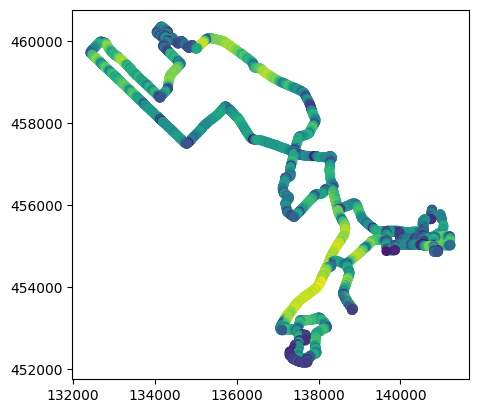

In [34]:
combined_gdf[combined_gdf['dBA_raw_arr'].str.len() > 0].plot(column='median_dBA_raw')

In [69]:
combined_gdf

,y,x,dBA_rivm,geometry,dBA_raw_arr,dBA_lin_arr,speed_arr,dBA_reg_arr,median_speed,median_dBA_raw,median_dBA_reg_adj
0,461585.0,129735.0,50,POINT (129735.000 461585.000),[],[],[],[],NaN,NaN,NaN
1,461585.0,129745.0,50,POINT (129745.000 461585.000),[],[],[],[],NaN,NaN,NaN
2,461585.0,129755.0,51,POINT (129755.000 461585.000),[],[],[],[],NaN,NaN,NaN
3,461585.0,129765.0,51,POINT (129765.000 461585.000),[],[],[],[],NaN,NaN,NaN
4,461585.0,129775.0,51,POINT (129775.000 461585.000),[],[],[],[],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1502727,450115.0,142775.0,59,POINT (142775.000 450115.000),[],[],[],[],NaN,NaN,NaN
1502728,450115.0,142785.0,62,POINT (142785.000 450115.000),[],[],[],[],NaN,NaN,NaN
1502729,450115.0,142795.0,66,POINT (142795.000 450115.000),[],[],[],[],NaN,NaN,NaN
1502730,450115.0,142805.0,66,POINT (142805.000 450115.000),[],[],[],[],NaN,NaN,NaN


## setting up vis

In [91]:
combined_gdf.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

<Figure size 640x480 with 0 Axes>

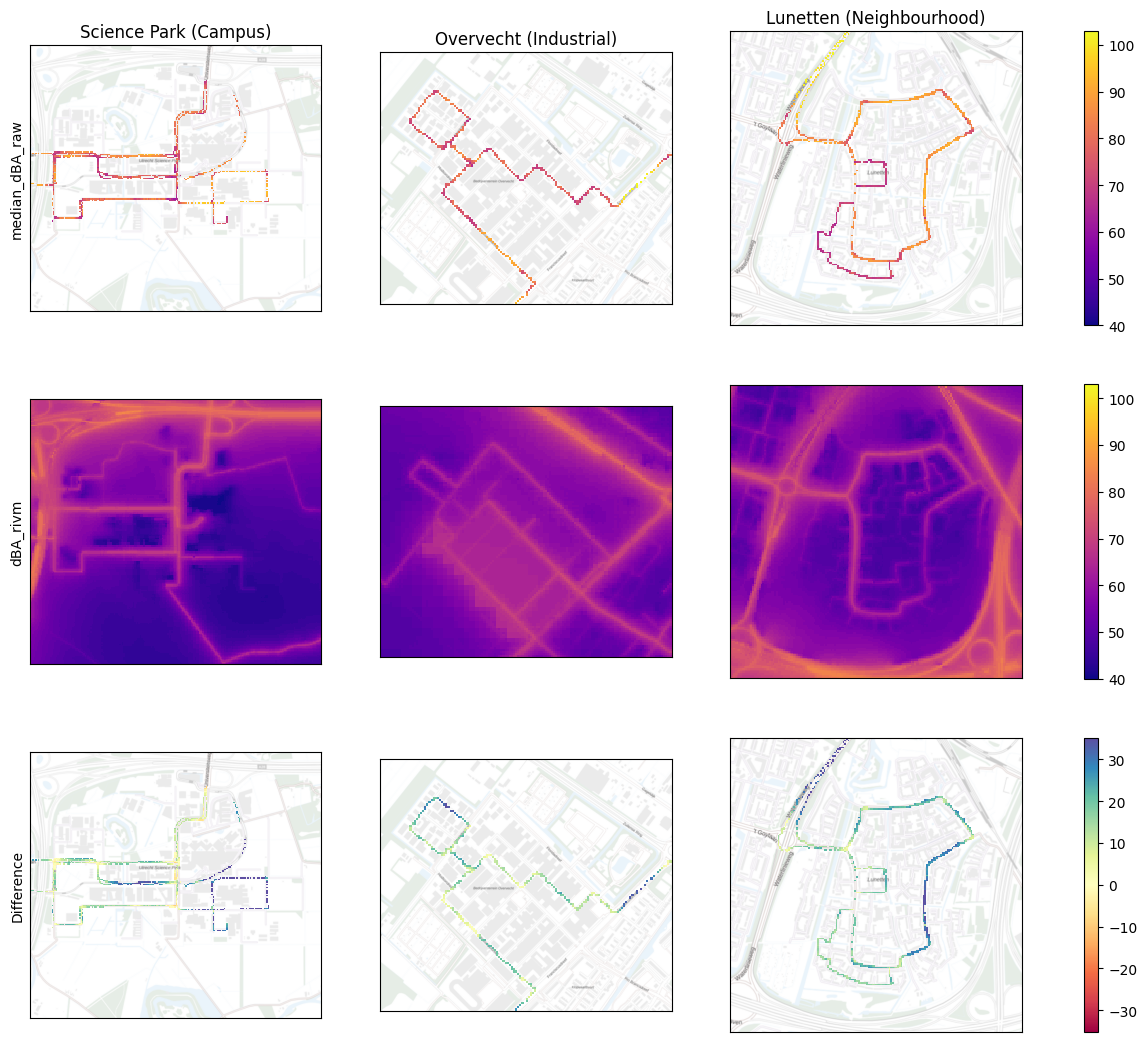

In [117]:
# define boundaries for each area of interest
sciencepark_camps_bbox = (139486.6244,454224.0538,141610.1082,456148.5016)
overvecht_industrial_bbox = (133896.3509,459362.9394,135283.9049,460551.7433)
lunetten_neighbourhood_bbox = (136783.0826,451879.0786,138490.1231,453599.2073)
bbox_masks = [sciencepark_camps_bbox, overvecht_industrial_bbox, lunetten_neighbourhood_bbox]
area_bbox_masks = {
    'Science Park (Campus)': sciencepark_camps_bbox,
    'Overvecht (Industrial)': overvecht_industrial_bbox,
    'Lunetten (Neighbourhood)': lunetten_neighbourhood_bbox
}



#calling plot functions
plt.tight_layout()
fig = create_comparison_plot(combined_gdf, area_bbox_masks, 'median_dBA_raw', 'dBA_rivm')
print()
# fig.show()

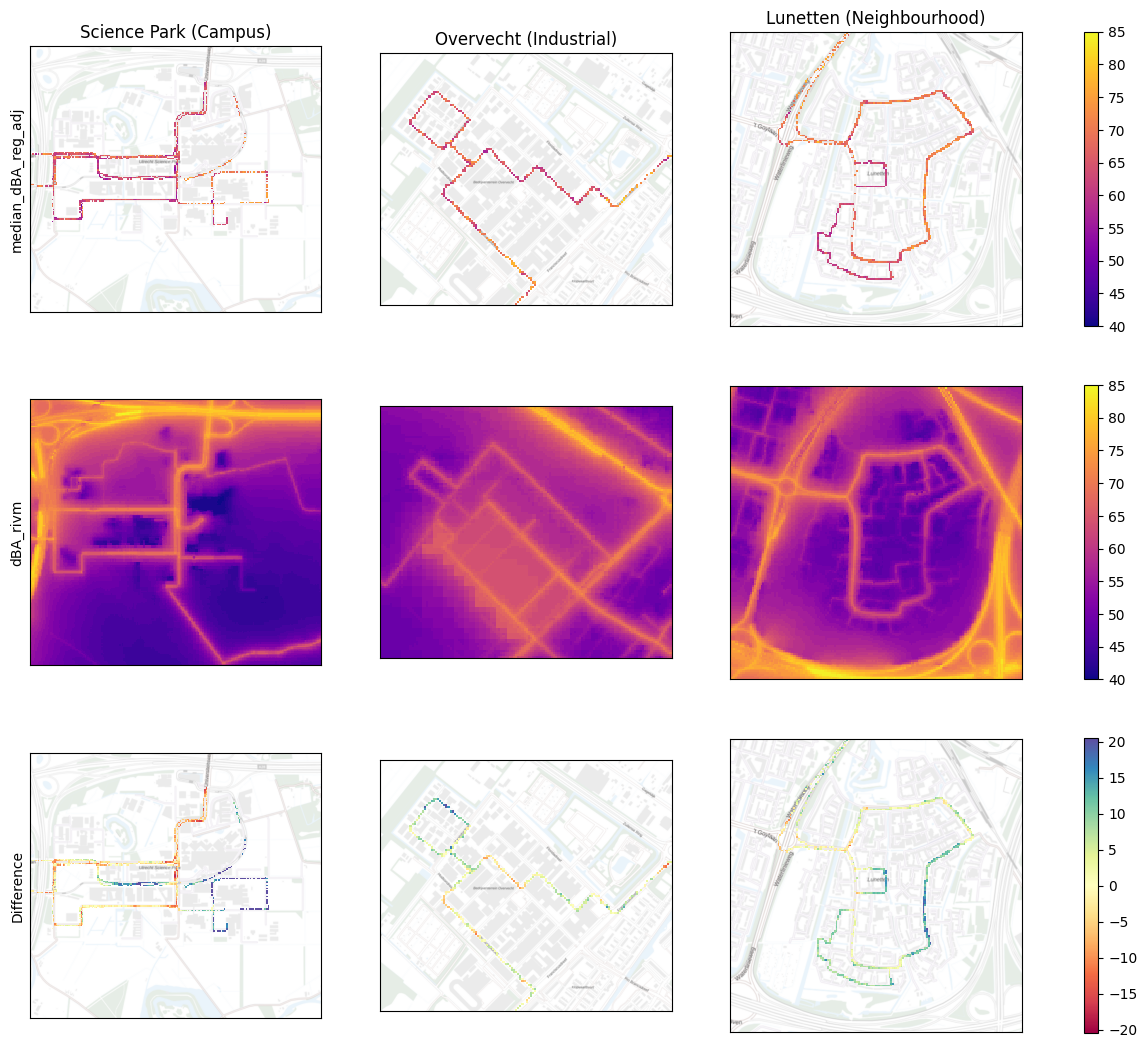

In [118]:
fig = create_comparison_plot(combined_gdf, area_bbox_masks, 'median_dBA_reg_adj', 'dBA_rivm')
print()